# Reconstruction Sandbox
This notebook is a test-bed for regularization and reconstruction methods

In [14]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

# Load motiondeblur module and Dataset class
import libwallerlab.projects.motiondeblur as md
# import htdeblur as md
from libwallerlab.utilities.io import Dataset, isDataset

# Platform imports
import os, glob
from os.path import expanduser

# Debugging imports
import llops as yp
import matplotlib.pyplot as plt
import numpy as np

yp.config.setDefaultBackend('numpy') #'arrayfire')
yp.config.setDefaultDatatype('float32')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define Output Path

In [15]:
output_path = os.path.expanduser('~/deblurring/datasets/regularized_output')
if not os.path.exists(output_path):
    os.mkdir(output_path)

## Load Data

In [16]:
!ls /home/sarah/deblurring/datasets/beads_coded_raster_100/

background.tif
beads_raster_coded_raster_100_motion_deblur_2019_01_28_12_55_06.json
beads_raster_coded_raster_100_motion_deblur_2019_01_28_12_55_06.tif
calibration.json
dark_current.tif


In [19]:
!ls /home/sarah/Dropbox/02-04-19-MotionDeblur-beads2/beads2_line_45ms_coded_raster_100_motion_deblur_2019_02_04_16_45_36

background.tif
beads2_line_45ms_coded_raster_100_motion_deblur_2019_02_04_16_45_36.json
beads2_line_45ms_coded_raster_100_motion_deblur_2019_02_04_16_45_36.tif
calibration.json
dark_current.tif


In [20]:
dataset_full_path = '/home/sarah/deblurring/datasets/beads_coded_raster_100/'
dataset_full_path = '/home/sarah/Dropbox/02-04-19-MotionDeblur-beads2/beads2_line_45ms_coded_raster_100_motion_deblur_2019_02_04_16_45_36'
# Create dataset object (loads metadata)
dataset = Dataset(dataset_full_path, use_median_filter=False, subtract_mean_dark_current=False, force_type='motion_deblur')

Loading 1 frames...


## Perform Registration and Normalization

In [21]:
force = True

# Perform registration
dataset.motiondeblur.register(force=force)

# Perform normalization
dataset.motiondeblur.normalize(force=force)

# Perform kernel shape 
dataset.metadata.calibration['blur_vector'] = {'scale': {'axis': 1, 'factor': 1}}

Loading 18 frames...


In [22]:
recon.y_list[0].dtype

dtype('float32')

## Solve For Single Segment

In [29]:
dataset.frame_mask = [10,11,12,13,14]

# Create recon object
recon = md.recon.Reconstruction(dataset, alpha_blend_distance=1000, normalize=False, use_psf=False, estimate_background_poly=True)

# Perform reconstruction
recon.reconstruct(iteration_count=100, step_size=1, frame_number=4, mode='global', reg_types={})

Minimizing function:


<IPython.core.display.Latex object>

|  Iter  |      Cost      | Elapsed time (s) |  Norm of Step  | Memory Usage (CPU/GPU) |
+ ------ + -------------- + ---------------- + -------------- + ---------------------- +


/home/sarah/deblurring/libwallerlab/submodules/llops/llops/fft.py:246: ComplexWarning: Casting complex values to real discards the imaginary part
  y[:] = sp.fftpack.ifftshift(sp.fftpack.ifft2(sp.fftpack.ifftshift(x, axes=axes), axes=axes), axes=axes)


|    0   |    2.07e+12    |       0.00       |    0.00e+00    | 7168.4 MB /    0.0 MB  |
|   10   |    4.92e+09    |     160.01       |    5.30e+03    | 7805.3 MB /    0.0 MB  |
|   20   |    2.17e+09    |     324.46       |    1.24e+04    | 7805.2 MB /    0.0 MB  |
|   30   |    1.08e+09    |     489.24       |    1.36e+04    | 7805.5 MB /    0.0 MB  |
|   40   |    6.52e+08    |     658.27       |    1.02e+04    | 7805.3 MB /    0.0 MB  |
|   50   |    4.30e+08    |     822.24       |    7.27e+03    | 7805.4 MB /    0.0 MB  |
|   60   |    3.05e+08    |     1039.74       |    5.58e+03    | 7805.2 MB /    0.0 MB  |
|   70   |    2.29e+08    |     1207.69       |    4.57e+03    | 7805.0 MB /    0.0 MB  |
|   80   |    1.77e+08    |     1372.25       |    3.86e+03    | 7805.4 MB /    0.0 MB  |
|   90   |    1.40e+08    |     1537.60       |    3.27e+03    | 7805.2 MB /    0.0 MB  |
|  100   |    1.13e+08    |     1696.17       |    2.76e+03    | 7805.5 MB /    0.0 MB  |


In [27]:
dataset.frame_mask = [10,11,12,13,14]
dataset.frame_mask = [13,14]

# Create recon object
recon = md.recon.Reconstruction(dataset, alpha_blend_distance=1000, normalize=False, use_psf=False, estimate_background_poly=True)

# Perform reconstruction
recon.reconstruct(iteration_count=100, step_size=1, frame_number=4, mode='global', reg_types={})


# Save result
recon.save(output_path, filename=recon.dataset.metadata.file_header + '_no_median', formats=['npz'], save_raw=False, downsample=4)

Minimizing function:


<IPython.core.display.Latex object>

|  Iter  |      Cost      | Elapsed time (s) |  Norm of Step  | Memory Usage (CPU/GPU) |
+ ------ + -------------- + ---------------- + -------------- + ---------------------- +


/home/sarah/deblurring/libwallerlab/submodules/llops/llops/fft.py:246: ComplexWarning: Casting complex values to real discards the imaginary part
  y[:] = sp.fftpack.ifftshift(sp.fftpack.ifft2(sp.fftpack.ifftshift(x, axes=axes), axes=axes), axes=axes)


|    0   |    9.25e+11    |       0.00       |    0.00e+00    | 17752.8 MB /    0.0 MB  |
|   10   |    2.29e+09    |      78.27       |    3.73e+03    | 17949.0 MB /    0.0 MB  |
|   20   |    9.96e+08    |     158.65       |    8.18e+03    | 17901.7 MB /    0.0 MB  |
|   30   |    4.84e+08    |     240.21       |    9.03e+03    | 17901.7 MB /    0.0 MB  |
|   40   |    2.85e+08    |     320.57       |    6.75e+03    | 17949.6 MB /    0.0 MB  |
|   50   |    1.81e+08    |     399.69       |    4.78e+03    | 17902.2 MB /    0.0 MB  |
|   60   |    1.24e+08    |     477.01       |    3.63e+03    | 17901.8 MB /    0.0 MB  |
|   70   |    9.04e+07    |     557.27       |    2.95e+03    | 17949.6 MB /    0.0 MB  |
|   80   |    6.75e+07    |     635.73       |    2.46e+03    | 17902.0 MB /    0.0 MB  |
|   90   |    5.09e+07    |     712.55       |    2.03e+03    | 17902.1 MB /    0.0 MB  |
|  100   |    3.89e+07    |     788.94       |    1.65e+03    | 17949.7 MB /    0.0 MB  |
Saved .npz

In [31]:
recon.save(output_path, filename=recon.dataset.metadata.file_header + '_no_median', formats=['npz'], save_raw=False, downsample=4)

Saved .npz file to /home/sarah/deblurring/datasets/regularized_output/beads2_line_45ms_coded_raster_100_motion_deblur_2019_02_04_16_45_36_no_median_regularize=[].npz


<IPython.core.display.Javascript object>


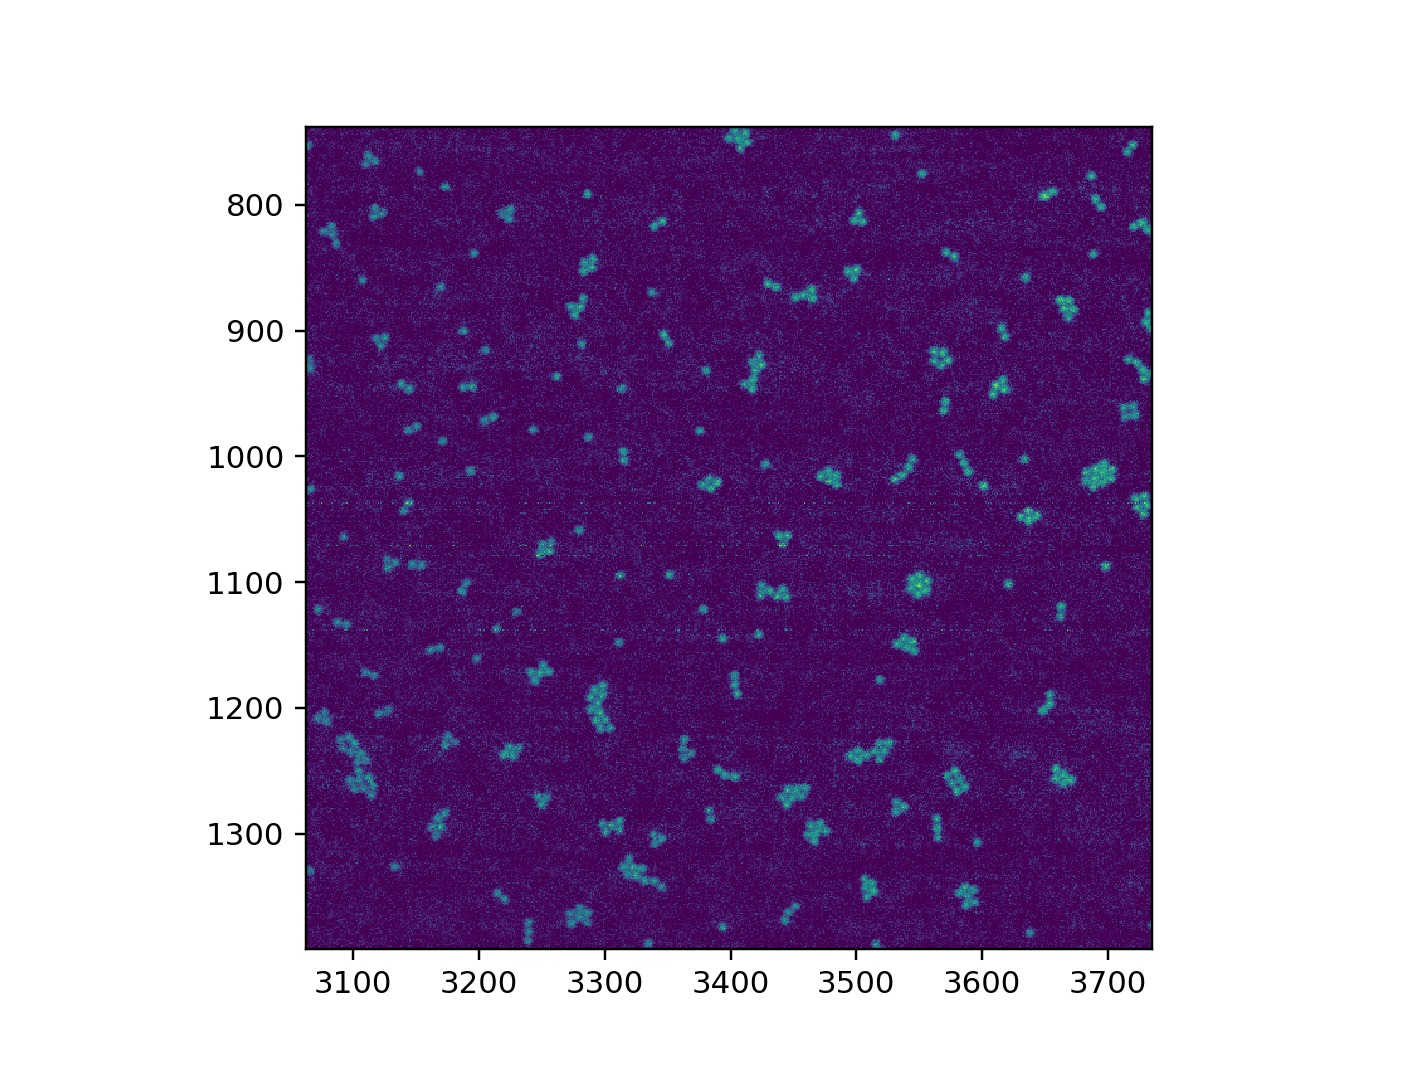

In [30]:
plt.figure()
plt.imshow(recon.object_recovered)
plt.clim(400, 4000)

<IPython.core.display.Javascript object>


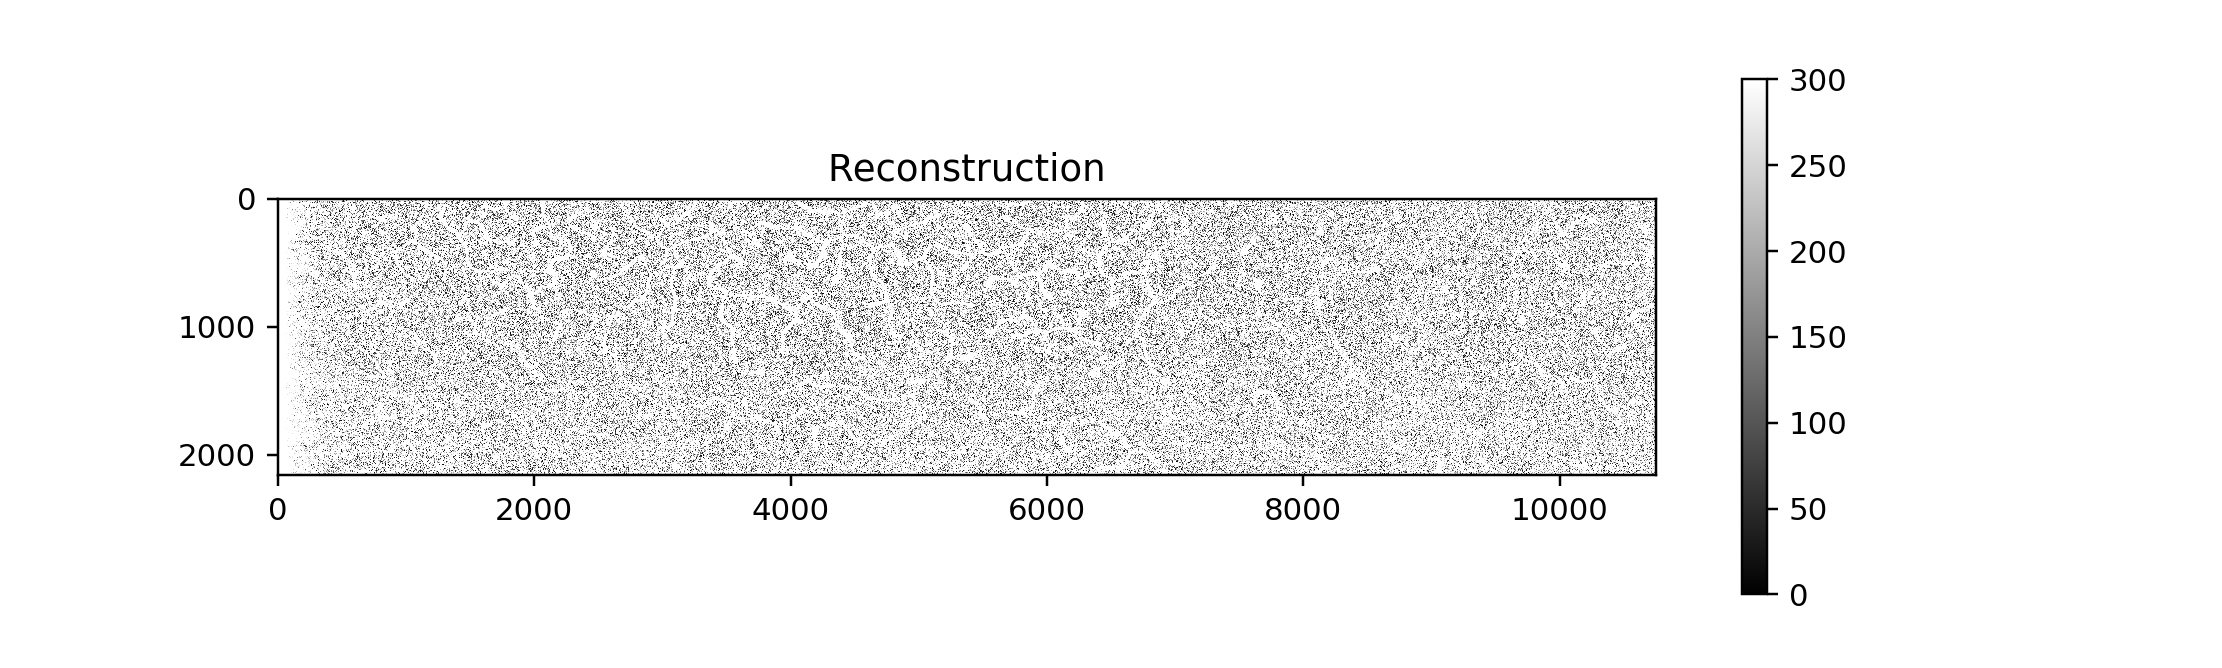

In [11]:
recon.show()
plt.clim(0,300)

## Calculate DNF

In [12]:
x = dataset.motiondeblur.blur_vectors()[0][0][0]

# Normalize
x = x / yp.scalar(yp.sum(x))

# Take fourier transform intensity
x_fft = yp.Ft(x)
sigma_x = yp.abs(x_fft) ** 2

# Calculate DNF
np.sqrt(1 / len(x) * np.sum(1 / sigma_x))

25.693665622580987

## Loop Over Segments

In [ ]:
for segment_index in dataset.motiondeblur.position_segment_indicies_full:
    # Set segment index
    dataset.motiondeblur.position_segment_indicies = [segment_index]
    
    # Create recon object
    recon = md.recon.Reconstruction(dataset, alpha_blend_distance=1000, pad_mode='mean', )

    # Perform reconstruction
#     recon.reconstruct(iteration_count=-1, step_size=1, frame_number=4, mode='global', reg_types={'l2': 1e-4})
    recon.reconstruct(iteration_count=100, step_size=1, frame_number=4, mode='global', reg_types={'l2': 1e-4})

    # Save result
    recon.save(output_path, filename=recon.dataset.metadata.file_header, formats=['png', 'npz'], save_raw=True, downsample=4)

In [ ]:
# Try with L1 Sparsity